In [7]:
import sys
sys.path.append('./helpers')
sys.path.append('./optimizers')

In [8]:
# External libraries
import pandas as pd
import numpy as np
import importlib
import matplotlib.pyplot as plt
import networkx as nx
from deap import gp

# Custom functions and classes
from pymoo_optimizer import PymooOptimizer
import benchmark as Benchmark
import data_provider as dp
import feature_evolver as fe

In [9]:
x_train, x_test, x_val, y_train, y_test, y_val = dp.get_train_test_validation_data('students', 0.8, 0.1)

x_train.columns = x_train.columns.str.replace(' ', '_')
x_test.columns = x_test.columns.str.replace(' ', '_')
x_val.columns = x_val.columns.str.replace(' ', '_')

WARNING
At least one column has heen dropped due to being non-numeric value.


In [10]:
optimizer = PymooOptimizer(x_train, x_val, y_train, y_val)
solution, score = optimizer.optimize(64, 100, Benchmark.regressor_r2_score, verbose = False, repeats=5)

In [11]:
raw_score = np.round(Benchmark.regressor_r2_score(x_train, x_test, y_train, y_test, 5), 4)
optimized_score = np.round(Benchmark.regressor_r2_score(x_train.loc[:, solution], x_test.loc[:, solution], y_train, y_test, 5), 4)

print(f'After optimization, R2 score changed from {raw_score} to {optimized_score}\n\n' +
        f'Optimal contains {np.round((x_train.shape[1] - np.sum(solution)) / x_train.shape[1] * 100, 1)}% less columns than the original dataset, ' +
        f'reducing from {x_train.shape[1]} to {np.sum(solution)}\n\nSelected columns are: {", ".join(x_train.columns[solution].tolist())}')


After optimization, R2 score changed from 0.4919 to 0.6794

Optimal contains 93.3% less columns than the original dataset, reducing from 15 to 1

Selected columns are: G2


In [ ]:
optimizer_constructor = lambda x_train, x_val, y_train, y_val: PymooOptimizer(x_train, x_val, y_train, y_val)
x_train_2, x_test_2, x_val_2 = fe.evolve_new_feature_set(optimizer_constructor, x_train, x_val, y_train, y_val, x_test, verbose=False,
                                                        heuristics=Benchmark.regressor_r2_score, epochs=50, repeats=3,
                                                        min_features=1, max_features=10)

score = np.round(Benchmark.regressor_r2_score(x_train, x_test, y_train, y_test, 5), 4)
new_score= np.round(Benchmark.regressor_r2_score(x_train_2, x_test_2, y_train, y_val, 5), 4)

print(f'After feature creation, R2 score was equal to {new_score}\n\n' +
        f'With previous data, it was {score}\n\n' +
        f'Optimal contains {100 - np.round(x_train_2.shape[1] / x_train.shape[1] * 100, 1)}% less columns than the original dataset')

After feature creation, R2 score was equal to 0.7616

With previous data, it was 0.4827

Optimal contains 93.3% less columns than the original dataset


In [24]:
import warnings
warnings.filterwarnings("ignore", module='evolutionary_forest')
warnings.filterwarnings("ignore", module='deap')
warnings.filterwarnings("ignore", module='lightgbm')

In [18]:
from evolutionary_forest.forest import EvolutionaryForestRegressor
from evolutionary_forest.utils import get_feature_importance, plot_feature_importance, feature_append
from sklearn.metrics import r2_score

r = EvolutionaryForestRegressor(max_height=3, normalize=True, select='AutomaticLexicase',
                                gene_num=10, boost_size=100, n_gen=20, n_pop=200, cross_pb=1,
                                base_learner='Random-DT', verbose=False)
r.fit(x_train, y_train)
print("Evolutionary forest R2: ", r2_score(y_test, r.predict(x_test)))

Evolutionary forest R2:  0.694396666005574


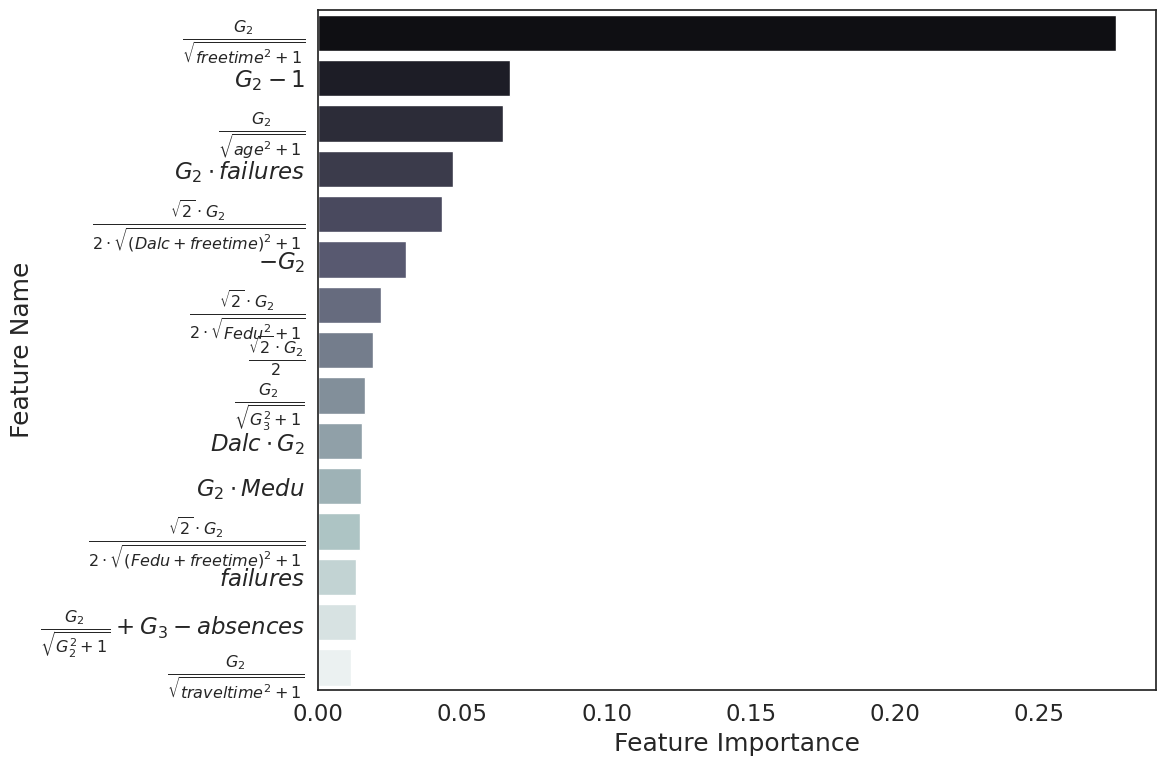

In [19]:
feature_importance_dict = get_feature_importance(r)
plot_feature_importance(feature_importance_dict)

In [20]:
from sklearn.ensemble import ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor

# Synthesize new features
code_importance_dict = get_feature_importance(r, simple_version=False)
top_features = list(code_importance_dict.keys())[:len(code_importance_dict) // 2]
new_train = feature_append(r, r.x_scaler.transform(x_train), top_features, only_new_features=True)
new_test = feature_append(r, r.x_scaler.transform(x_test), top_features, only_new_features=True)

# Train a new model on synthesized features
new_r = RandomForestRegressor()
new_r.fit(new_train, y_train)
print(r2_score(y_test, new_r.predict(new_test)))

0.6775260174737217


In [28]:
from lightgbm import LGBMRegressor

regressor_list = ['RF', 'ET', 'AdaBoost', 'GBDT', 'DART', 'XGBoost', 'LightGBM']

# Normalize training and testing data
x_train_reg, x_test_reg = r.x_scaler.transform(x_train), r.x_scaler.transform(x_test)

# Get feature importance and select top features
code_importance_dict = get_feature_importance(r, simple_version=False)
top_features = list(code_importance_dict.keys())[:len(code_importance_dict.keys()) // 2]

# Replace the original dataset with new features
new_train = feature_append(r, x_train_reg, top_features, only_new_features=True)
new_test = feature_append(r, x_test_reg, top_features, only_new_features=True)

# Define regressors
regressor_dict = {
    'RF': RandomForestRegressor(n_estimators=200, n_jobs=-1, verbose=False),
    'ET': ExtraTreesRegressor(n_estimators=200, n_jobs=-1, verbose=False),
    'AdaBoost': AdaBoostRegressor(n_estimators=200),
    'GBDT': GradientBoostingRegressor(n_estimators=200, verbose=False),
    'DART': LGBMRegressor(n_jobs=1, n_estimators=200, boosting_type='dart',
                            xgboost_dart_mode=True, verbose=-1),
    'XGBoost': XGBRegressor(n_jobs=1, n_estimators=200, verbose=False),
    'LightGBM': LGBMRegressor(n_jobs=1, n_estimators=200, verbose=-1),
}

scores_base = []
scores_enhanced = []

# Train and evaluate regressors on original and new features
for regr in regressor_list:
    regressor = regressor_dict[regr]
    
    # Train on original features
    regressor.fit(x_train_reg, y_train)
    score = np.round(r2_score(y_test, regressor.predict(x_test_reg)), 4)
    scores_base.append((regr, score))

    # Train on new features
    regressor.fit(new_train, y_train)
    score = np.round(r2_score(y_test, regressor.predict(new_test)), 4)
    scores_enhanced.append((regr, score))

# Calculate mean scores for each algorithm
base_frame = pd.DataFrame(scores_base, columns=['algorithm', 'score'])
print("Original solution\n", base_frame.groupby(['algorithm']).mean())

improved_frame = pd.DataFrame(scores_enhanced, columns=['algorithm', 'score'])
print("\n\nOptimized solution\n", improved_frame.groupby(['algorithm']).mean())

# Calculate the improvement in scores
base_score = base_frame.groupby(['algorithm']).mean()
improved_score = improved_frame.groupby(['algorithm']).mean()
print("\n\nDifference\n", improved_score - base_score)

Original solution
             score
algorithm        
AdaBoost   0.6972
DART       0.5131
ET         0.7015
GBDT       0.6394
LightGBM   0.4784
RF         0.6952
XGBoost    0.6441


Optimized solution
             score
algorithm        
AdaBoost   0.6894
DART       0.6169
ET         0.6691
GBDT       0.6342
LightGBM   0.6118
RF         0.6783
XGBoost    0.6590


Difference
             score
algorithm        
AdaBoost  -0.0078
DART       0.1038
ET        -0.0324
GBDT      -0.0052
LightGBM   0.1334
RF        -0.0169
XGBoost    0.0149


/home/user/.local/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [22:40:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/home/user/.local/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [22:40:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


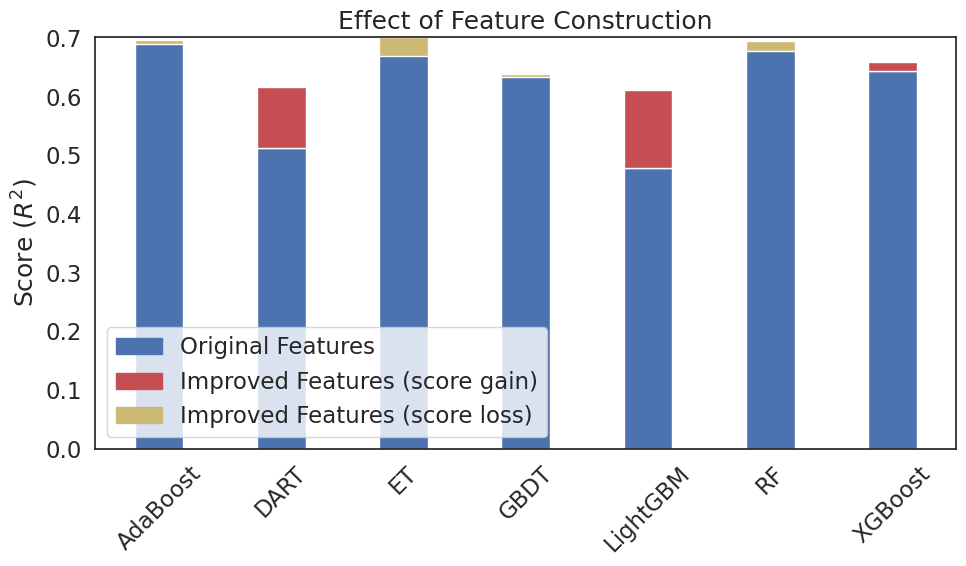

In [34]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

sns.set(style="white", font_scale=1.5)
width = 0.4
fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(base_score.index, base_score['score'], width, label='Original Features')
difference = improved_score['score'] - base_score['score']

colors = np.where(difference > 0, 'r', 'y')

ax.bar(base_score.index, difference, width, bottom=base_score['score'], color=colors)

ax.set_ylabel('Score ($R^2$)')
ax.set_title('Effect of Feature Construction')
handles = [
    mpatches.Patch(color='b', label='Original Features'),
    mpatches.Patch(color='r', label='Improved Features (score gain)'),
    mpatches.Patch(color='y', label='Improved Features (score loss)')
]

# Add custom legend
ax.legend(handles=handles)
plt.xticks(rotation=45)
plt.tight_layout()